<a href="https://colab.research.google.com/github/m-fila/uczenie-maszynowe-2021-22/blob/main/06_Bayes_spam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **SPAM vs. naiwny klasyfikator Bayesa**
Autor: Anna Dawid

## Wprowadzenie
Nigeryjski książę wciąż zarabia na użytkownikach elektronicznych skrzynek pocztowych ponad 700 tys. dolarów rocznie ([źródło](https://www.cnbc.com/2019/04/18/nigerian-prince-scams-still-rake-in-over-700000-dollars-a-year.html))! Jak to możliwe?

Pierwsza przyczyna jest natury psychologicznej. Ofiary są poddawane "perfekcyjnej burzy pokuszeń", jak ujął to psycholog w wywiadzie, do którego linka dałam Wam powyżej. Spammerzy łączą granie na ludzkiej chciwości, ale także na pragnieniu bycia bohaterem. W końcu kto nie chciałby zarobić na byciu wspaniałomyślnym i szczodrym? W tej kwestii możemy pracować wyłącznie nad sobą.

Możemy za to pracować nad filtrami antyspamowymi. Użyjemy techniki, która nazywa się "worek ze słowami" (bag of words) w połączeniu z naiwnym klasyfikatorem Bayesa. Choć to prosty klasyfikator, z powodzeniem jest używany współcześnie (np. [SpamAssassin](https://cwiki.apache.org/confluence/display/spamassassin/BayesInSpamAssassin)).

Notebook oparty na tutorialach:
*   https://towardsdatascience.com/spam-classifier-in-python-from-scratch-27a98ddd8e73
*   https://towardsdatascience.com/spam-filtering-using-naive-bayes-98a341224038


## Import danych treningowych
https://www.kaggle.com/uciml/sms-spam-collection-dataset

To dane przygotowane przez Almeida et al. na podstawie forum brytyjskiego, gdzie użytkownicy skarżą się na spamowe SMSy. Każdy wiersz składa się z kolumny opisującej czy wiadomość jest spamem, czy nie ('spam' czy 'ham'), a druga zawiera treść wiadomości.

Jak na ćwiczeniach o regresji logistycznej klonujemy repozytorium, żeb móc korzystać z zestawu danych:

In [1]:
# odkomentuj zeby pobrac repozytorium, mozesz tez wgrac samemu odpowiedni plik z danymi
#!git clone https://github.com/m-fila/uczenie-maszynowe-2021-22

Do pracy z danymi tekstowymi bardzo przydatna jest biblioteka [pandas](https://www.shanelynn.ie/using-pandas-dataframe-creating-editing-viewing-data-in-python/).

In [2]:
import numpy as np
import pandas as pd

In [3]:
mails = pd.read_csv('uczenie-maszynowe-2021-22/dane/spam_dataset.csv', encoding='latin-1')
mails.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


Wyczyśćmy ten zbiór danych. Usuńmy niepotrzebne kolumny i zastąpmy nazwy 'v1' i 'v2' czymś bardziej przyjaznym.

In [4]:
mails = mails.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis=1)
mails.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [5]:
mails = mails.rename(columns={"v1": "klasa", "v2": "tekst"})
mails.head()

,klasa,tekst
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


Zobaczmy jak wyglądają przykładowe dane o numerze jakimkolwiek.

In [6]:
id = 57

Treść wiadomości:

In [7]:
mails['tekst'][id]

"Sorry, I'll call later in meeting."

Kategoria:

In [8]:
mails['klasa'][id]

'ham'

Ile mamy tych maili?

In [9]:
mails.shape

(5572, 2)

## Analiza częstości występowania słów w obu klasach za pomocą biblioteki WordCloud

To biblioteka pozwalająca generować śliczne obrazki, na których wielkość słów odpowiada częstości jego występowania w danym zbiorze.

In [10]:
!pip3 install wordcloud
import wordcloud

You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.8/bin/python3.8 -m pip install --upgrade pip' command.


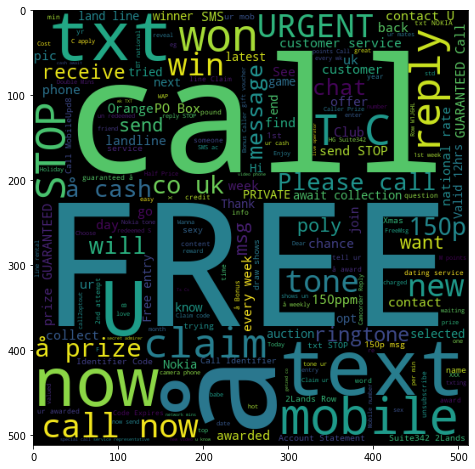

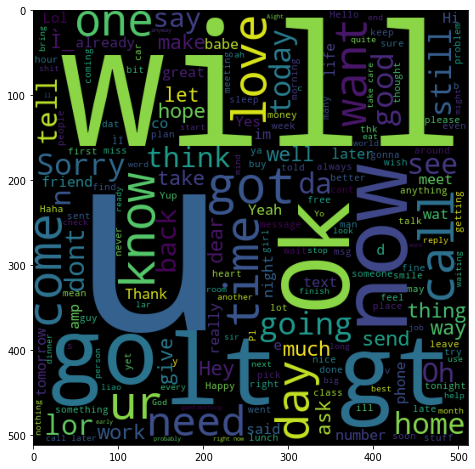

In [11]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# najpierw słowa ze spamu
spam_words = " ".join(list(mails [mails['klasa']=='spam']['tekst'] ))
spam_plot = WordCloud(width = 512, height = 512).generate(spam_words)

plt.figure(figsize=(10,8))
plt.imshow(spam_plot)

# teraz słowa z normalnych wiadomosci
ham_words = " ".join(list(mails [mails['klasa']=='ham']['tekst'] ))
ham_plot = WordCloud(width = 512, height = 512).generate(ham_words)

plt.figure(figsize=(10,8))
plt.imshow(ham_plot)

Przygotujmy dane do treningu i testu klasyfikatora:

In [12]:
from sklearn.model_selection import train_test_split

X = mails.tekst
y = mails.klasa
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

Przekodowujemy wiadomości na wektory cech.  Korzystamy z funkcji: [sklearn.feature_extraction.text.CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html)

In [13]:
from sklearn.feature_extraction.text import CountVectorizer
# stwórz instancje obiektu CountVectorizer
vectorizer = ...
# naucz vectorizer słownika i przetransformuj dane uczące (jest odpowiednia metoda, która robi dwie rzeczy na raz)
X_train = ...

Wypisz rozmiary danych treningowych:

In [14]:
print("Dane treningowe: n_samples: %d, n_features: %d" % X_train.shape)

Dane treningowe: n_samples: 3900, n_features: 7068


Dane uczące są przechowywane w macierzy rzadkiej (sparse matrix). Proszę podejrzeć jak wyglądają tak przekodowane dane:

In [15]:
print(X_train[57])

  (0, 4401)	1
  (0, 3857)	1
  (0, 6195)	1
  (0, 6871)	1
  (0, 4029)	1
  (0, 7019)	1
  (0, 6277)	1
  (0, 6199)	1
  (0, 6806)	1
  (0, 1451)	1
  (0, 6717)	1
  (0, 1181)	1
  (0, 1862)	1
  (0, 6022)	1
  (0, 4478)	1
  (0, 2623)	1
  (0, 6931)	1
  (0, 3302)	1
  (0, 6330)	1
  (0, 5798)	1
  (0, 2441)	1
  (0, 6629)	2
  (0, 3883)	1
  (0, 6972)	1


 Wektoryzujemy też dane testowe, wykorzystując już stworzony na podstawie danych treningowych wektor słów:

In [16]:
# użyj vectorizer żeby przetransformować dane ze zbioru testowego (teraz bez fitowania!)
X_test = ...
print("Dane testowe: n_samples: %d, n_features: %d" % X_test.shape)

Dane testowe: n_samples: 1672, n_features: 7068


Odwrotne mapowanie z cech na słowa:

In [17]:
feature_names = vectorizer.get_feature_names()
feature_names = np.array(feature_names)

Tworzymy instancję i uczymy klasyfikator MultinomialNB

In [18]:
from sklearn.naive_bayes import MultinomialNB
# stwórz obiekt klasyfikatora
clf = ...
# naucz klasyfikator na zbiorze uczącym
...

MultinomialNB()

## Ocena jakości: jak zwykle będziemy korzystać z funkcji zaimplementowanych w [sci-kit](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics)

In [19]:
y_pred = ... # obliczamy predykcję dla tekstów ze zbioru testowego

In [20]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

accur = ... # policz dokładność
print("Dokładność: %0.3f" % accur)
print("Classification report:") 
# wypisz raport klasyfikacji 
print(...)

print("Macierz błędów") 
# wypisz macierz (confusion matrix)
print(...)

Dokładność: 0.992
Classification report:
              precision    recall  f1-score   support

         ham       0.99      1.00      1.00      1457
        spam       0.98      0.95      0.97       215

    accuracy                           0.99      1672
   macro avg       0.99      0.98      0.98      1672
weighted avg       0.99      0.99      0.99      1672

Macierz błędów
[[1453    4]
 [  10  205]]


Sprawdźmy, czego właściwie maszyna się nauczyła:

In [21]:
print("Słowa, które z największą pewnością wskazują maszynie, że wiadomość to spam:")
# np.argsort zwraca indeksy w oryginalnej tablicy, które odpowiadają posortowanej tablicy, np.:
# np.argsort([3,1,2]) ---> [1,2,0]
# .coef_[0] zwraca nam tablicę współczynników -- po jednym dla każdej cechy. 
# Wkład do decyzji klasyfikatora jest proporcjonalny do wartości tych współczynników -- większy współczynnik = ważniejsza cecha
top10 = np.argsort(clf.coef_[0])[-10:]
bottom10 = np.argsort(clf.coef_[0])[:10]
print(feature_names[top10])

print("Słowa najmniej istotne przy klasyfikacji:")
print(feature_names[bottom10])

Słowa, które z największą pewnością wskazują maszynie, że wiadomość to spam:
['txt' 'or' 'the' 'now' 'for' 'free' 'your' 'you' 'call' 'to']
Słowa najmniej istotne przy klasyfikacji:
['junna' 'natural' 'nattil' 'nationwide' 'nap' 'nanny' 'nange' 'nan'
 'nammanna' 'nature']


## Zastanówmy się, czy możemy jakoś ułatwić zadanie maszynie, wykorzystując naszą znajomość języka

Poszukajcie słowa, które nie występuje w zbiorze treningowym.

In [22]:
id = np.where(feature_names == 'supercalifragilisticexpialidocious') #"call mr barosa now to get for free our product"
print(id)

message = ['Life is supercalifragilisticexpialidocious']
our_message = vectorizer.transform(message)
clf.predict(our_message)

(array([], dtype=int64),)


array(['ham'], dtype='<U4')

### Stemming (nawet nie będę próbować tego tłumaczyć na polski, to [bogate](https://pl.bab.la/slownik/angielski-polski/stemming) znaczeniowo słowo)

Polega na ujednoliceniu słów o tym samym rdzeniu znaczeniowym (o czym maszyna, oczywiście, nie ma szans wiedzieć). Np. dzięki stemmingowi słowa "go", "going" i "goes" są przyporządkowane tylko jednemu słowu "go". Można np. użyć gotowego algorytmu stemmingowego o nazwie [Porter Stemmer](https://tartarus.org/martin/PorterStemmer/).

In [23]:
id1 = np.where(feature_names == 'going')
id2 = np.where(feature_names == 'go')
print(id1, id2)

(array([2901]),) (array([2889]),)


In [24]:
!pip3 install nltk
import nltk
import ssl
# chcemy pobrac wytrenowany dla języka angielskeigo tokenizer Punkt
# poniższe linijki mają pomóc w przypadku problemów z ssl
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context
# pobieramy tokenizer
nltk.download('punkt')
# ładujemy przydatne funkcje
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.8/bin/python3.8 -m pip install --upgrade pip' command.


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/rafalmaselek/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [25]:
# przykładowy tekst
message = 'Applying classical methods of machine learning to the study of quantum systems (sometimes called quantum machine learning) is the focus of an emergent area of physics research'
# tokenizujemy czyli dzielimy tekst na słowa
words = word_tokenize(message)
print(words)
print()
# stwórz obiekt typu PorterStemmer
stemmer = ...
# użyj nowo stworzonego obiektu, żeby 'dostać temat' każdego ze słów
words = ...
print(words)

['Applying', 'classical', 'methods', 'of', 'machine', 'learning', 'to', 'the', 'study', 'of', 'quantum', 'systems', '(', 'sometimes', 'called', 'quantum', 'machine', 'learning', ')', 'is', 'the', 'focus', 'of', 'an', 'emergent', 'area', 'of', 'physics', 'research']

['appli', 'classic', 'method', 'of', 'machin', 'learn', 'to', 'the', 'studi', 'of', 'quantum', 'system', '(', 'sometim', 'call', 'quantum', 'machin', 'learn', ')', 'is', 'the', 'focu', 'of', 'an', 'emerg', 'area', 'of', 'physic', 'research']


Powtórzmy trening i testowanie naszego klasyfikatora na danych poddanych stemmingowi:

### Wracamy do pracy nad zbiorem mejli

In [27]:
# wczytaj cechy i klasy do zmiennych X i Y a następnie podziel na zbiory uczacy 70% i testowy 30%
X = ...
y = ...
X_train, X_test, y_train, y_test = ...
# stwórz instancje obiektu CountVectorizer
vectorizer = ...
# naucz vectorizer słownika i przetransformuj dane uczące
X_train = ... 
# przetransformuj dane testowe
X_test = ...
# stwórz naiwny bayesowski wielomianowy klasyfikator  
clf = ...
# naucz klasyfiaktor na zbiorze uczącym
...

MultinomialNB()

In [28]:
# policz predykcję naiwnego Bayesa na zbiorze tesotwym
y_pred = ...
# użyj predykcji aby policzyć dokładność (accuracy)
accur = ... # dokładność
print("Dokładność: %0.3f" % accur)
# wypisz raport klasyfikacji 
print("Classification report:") 
print(...)
 # wypisz macierz (confusion matrix)
print("Macierz błędów")
print(...)

Dokładność: 0.989
Classification report:
              precision    recall  f1-score   support

         ham       0.99      1.00      0.99      1465
        spam       0.99      0.91      0.95       207

    accuracy                           0.99      1672
   macro avg       0.99      0.96      0.97      1672
weighted avg       0.99      0.99      0.99      1672

Macierz błędów
[[1464    1]
 [  18  189]]


In [32]:
# Teraz wypiszmy słowa, które były najbardziej i najmniej pomocne przy klasyfikacji.
# Korzystając z wcześniejszych komórek uzupełnij poniższy kod.

# użyj vectorizer żeby dostać nazwy cech i przekonwertuj je do tablicy numpy
...
# print(feature_names[:10])

# wybierz indeksy dla top10 najważniejszych cech
top10 = ...
# wybierz indeksy dla 10 najmniej ważnych cech
bottom10 = ...

print("Słowa, które z największą pewnością wskazują maszynie, że wiadomość to spam:")
# wypisz wyrazy odpowiadające najważniejszym cechom
print(...)
print("Słowa najmniej istotne przy klasyfikacji:")
# wypisz wyrazy odpowiadające najmniej ważnym cechom
print(...)

Słowa, które z największą pewnością wskazują maszynie, że wiadomość to spam:
['is' 'or' 'now' 'the' 'for' 'free' 'your' 'you' 'call' 'to']
Słowa najmniej istotne przy klasyfikacji:
['je' 'mutations' 'musthu' 'mushy' 'mush' 'mus' 'murderer' 'murdered'
 'murder' 'murali']


## Gdybyście byli spammerami... Co moglibyście zrobić, znając tę technikę antyspamową?

### Stosowanie znaków specjalnych zamiast liter

In [30]:
our_message = vectorizer.transform(['call for free'])
print(clf.predict(our_message))
# podmieniamy literkę a na małpę @
our_tricky_message = vectorizer.transform(['c@ll for free'])
print(clf.predict(our_tricky_message))

['spam']
['ham']


### Wysyłanie obrazków z tekstem!
-> nakładki OCR (ang. optical character recognition)

Jakieś inne pomysły? :)

In [31]:
our_tricky_message = vectorizer.transform(['Call for free sex otherwise you miss a very important meeting'])
print(clf.predict(our_tricky_message))

['ham']


#### Dlaczego powyższa wiadomość została sklasyfikowana jako pożądana, chociaż jest ewidentnym przykładem spamu?